In [1]:
## Event Driven Simulation 

In [2]:
### Scheduling CoMP

In [1]:
clear all

In [145]:
import eds
import simpy
import numpy as np
import pandas as pd
import scipy
SCHEDULE_T=2
import matplotlib.pyplot as plt
import show as sh

In [231]:

#env = simpy.rt.RealtimeEnvironment(factor=1/10)

ue_list=np.array([])
ue_list2=np.array([])
#define UEs

    
max_prb=50
thr=6
cluster=[19,20]

ue_nr=10

x=np.append(np.ones(ue_nr)*19,np.ones(ue_nr)*20)
y=np.append(np.ones(ue_nr)*20,np.ones(ue_nr)*19)
sinr=np.random.randint(-2,10,ue_nr*2)
sinr2=np.array([])
for i in sinr:
    sinr2=np.append(sinr2, i+np.random.randint(2,10))

rt_nrt=np.array([])
rt_nrt=np.append(rt_nrt,np.ones(ue_nr*2)*0)

df=pd.DataFrame()
df['PCI Serving']=x
df['PCI Coord']=y
df['JT_1 SINR [lin]']=sinr
df['JT_2 SINR [lin]']=sinr2
df['usage']=rt_nrt
df['id']=np.arange(0,ue_nr*2)
   
df['PCI Serving']=df['PCI Serving'].astype('int')
df['PCI Coord']=df['PCI Coord'].astype('int')

df['JT_1 SINR [lin]']=df['JT_1 SINR [lin]'].astype('int')
df['JT_2 SINR [lin]']=df['JT_2 SINR [lin]'].astype('int')

df2=df

#### Important Properties

In [316]:
metric=[0,1]
size=1500
ue_dict=eds.df_to_ue_lists(df,[19,20],6,env)
ue_all=np.array([])
for i in cluster:
    ue_all=np.append(ue_all,ue_dict[i])

prb_number_comp=eds.calculate_prb_number(ue_all,max_prb)
prb_number_normal=max_prb-prb_number_comp


In [318]:
print('comp prb proportion',prb_number_comp/(prb_number_normal+prb_number_comp))
print('comp user proportion',len(ue_comp)/len(ue_all))


comp prb proportion 0.54
comp user proportion 0.35


In [320]:
env=simpy.Environment()
#Start processes
    
for i in cluster:
    ue_list=ue_dict[i]
    for j in np.arange(0,ue_nr):
        env.process(ue_list[j].best_effort(env,size))
        
ue_comp=np.array([]) #ues that use comp -> processed be central_scheduler
for i in cluster:
    ue_list=ue_dict[i]
    new_ue_list=np.array([])
    for j in ue_list:
        if(j.comp == 0):
            new_ue_list=np.append(new_ue_list,j)
        else:
            ue_comp=np.append(ue_comp,j)
    ue_dict[i]=new_ue_list #user without comp
    
env.process(eds.central_scheduler(env,ue_comp,SCHEDULE_T,[19,20],prb_number_comp,metric))

counter=0
for i in cluster:
    ue_list=ue_dict[i]
    ue_sep=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
    print(len(ue_sep))
    env.process(eds.scheduler(env,ue_sep,SCHEDULE_T,[19,20],max_prb,ue_list,prb_number_normal,metric))
    counter=counter+1
env.run(until=3000)

10
10


C:\Users\Caroline Zoll\EDS\eds.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\eds.py:211: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


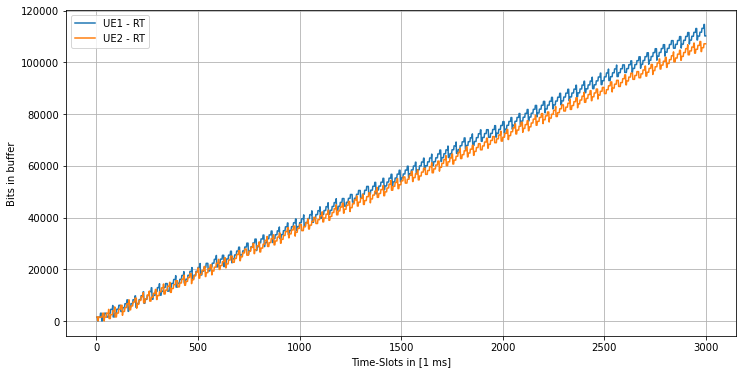

In [321]:
plt.figure(figsize=(12,6))
plt.plot(list(ue_all[2].mon.keys()),list(ue_all[2].mon.values()),label='UE1 - RT')
plt.plot(list(ue_all[15].mon.keys()),list(ue_all[15].mon.values()),label='UE2 - RT')
plt.xlabel('Time-Slots in [1 ms]')
plt.ylabel('Bits in buffer')
plt.legend(loc="upper left")
plt.grid()

No handles with labels found to put in legend.


CoMP-gain 0.9427025374191691
10% Quantil: -45.14770096626268
90% Quantil: 31.982458772456425
50% Quantil (Median): -1.4586475719299774


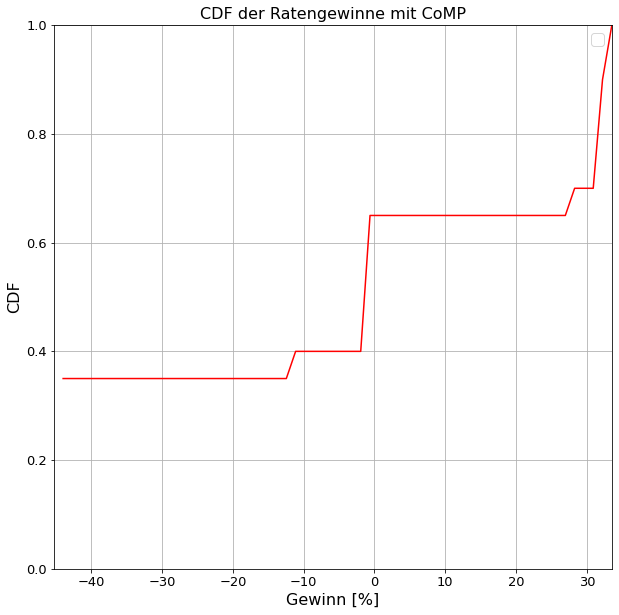

In [322]:
av=0
liste=np.array([])
for i in ue_all:
    liste=np.append(liste,((i.mR2/i.mR)-1)*100)
    av+=i.mR2/i.mR
av=av/(ue_nr*2)
print('CoMP-gain',av)

sh.cdf_1(liste,'','red','CDF der Ratengewinne mit CoMP',min(liste),max(liste),'Gewinn [%]',60)

In [347]:
max_prb=50
ran= np.arange(600,3000,100)
dict={}
speicher={}
sched_metric=[1,1]
queue_len=np.array([])
load1=np.array([])
load2=np.array([])

for k in ran:
    print('round',k)
    df=df2
    env=simpy.Environment()

    ue_dict=eds.df_to_ue_lists(df,[19,20],6,env)
    ue_all=np.array([])
    for i in cluster:
        ue_all=np.append(ue_all,ue_dict[i])

    prb_number_comp=eds.calculate_prb_number2(ue_all,max_prb)
    prb_number_comp=15
    prb_number_normal=max_prb-prb_number_comp

    #Start processes

    for i in cluster:
        ue_list=ue_dict[i]
        for j in np.arange(0,ue_nr):
            env.process(ue_list[j].best_effort(env,(k)))

    ue_comp=np.array([]) #ues that use comp -> processed be central_scheduler
    for i in cluster:
        ue_list=ue_dict[i]
        new_ue_list=np.array([])
        for j in ue_list:
            if(j.comp == 0):
                new_ue_list=np.append(new_ue_list,j)
            else:
                ue_comp=np.append(ue_comp,j)
        ue_dict[i]=new_ue_list #user without comp

    env.process(eds.central_scheduler(env,ue_comp,SCHEDULE_T,[19,20],prb_number_comp,sched_metric))

    counter=0
    for i in cluster:
        ue_list=ue_dict[i]
        ue_19=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
        env.process(eds.scheduler(env,ue_19,SCHEDULE_T,[19,20],max_prb,ue_list,prb_number_normal,sched_metric))
        counter=counter+1
    env.run(until=3000)
             
    av=0
    empty=0
    liste=np.array([])
    for i in ue_all:
        liste=np.append(liste,((i.mR2/i.mR)-1)*100)
        av+=i.mR2/i.mR
        if(i.queue.level!=0):
            empty=1

    queue_len=np.append(queue_len, empty)
    av=av/(ue_nr*2)
    dict.update({k:liste})
    
    count=0
    count2=0
    for i in ue_all[0:10]:
        count+=np.ceil(k/i.tbs)
    for i in ue_all[10:20]:
        count2+=np.ceil(k/i.tbs)
    
    total=max_prb*5 #total number of prbs 

    load1=np.append(load1,count*100/total)
    load2=np.append(load2,count2*100/total)
    
    speicher.update({k:ue_all})
    

round 600
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp


C:\Users\Caroline Zoll\EDS\eds.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\eds.py:211: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))



empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty que

empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queu

empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queu

empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queu

empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queu

empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queu

empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queu

empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queu

empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queu

empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queu

empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queu

empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queu

empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queue - no comp
empty queu

In [348]:
l=np.array([])
l2=np.array([])
for i in ran:
    x=dict.get(i)
    m=x[0:ue_nr].mean()
    m2=x[ue_nr:ue_nr*2].mean()
    l=np.append(l,m)
    l2=np.append(l2,m2)
min_val=min(np.append(load1,load2))
max_val=max(np.append(load1,load2))

#### Auswertung Cell-1

(54.0, 260.0)

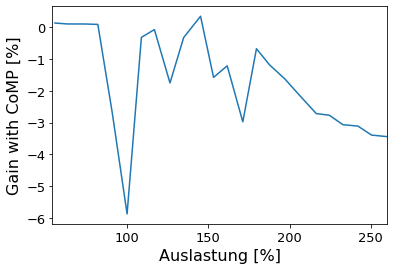

In [349]:
plt.plot(load1,l,)
plt.xlabel('Auslastung [%]')
plt.ylabel('Gain with CoMP [%]')
ax = plt.gca()
ax.set_xlim([min_val,max_val])

#### Auswertung Cell-2

(54.0, 260.0)

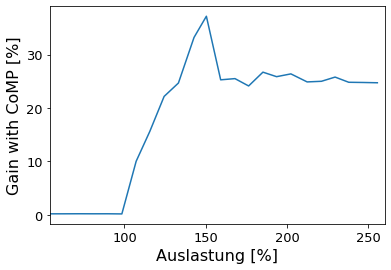

In [350]:
plt.plot(load2,l2)
plt.xlabel('Auslastung [%]')
plt.ylabel('Gain with CoMP [%]')
ax = plt.gca()
ax.set_xlim([min_val,max_val])

#### Auswertung all Cells

No handles with labels found to put in legend.


CoMP-gain 0.971349359836329
10% Quantil: -2.6543350620944515
90% Quantil: 0.34734758340384103
50% Quantil (Median): 0.048787665066940544


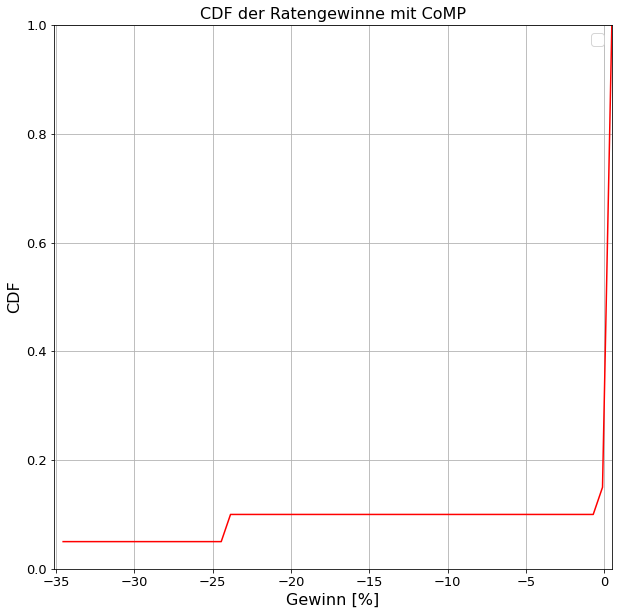

In [351]:
av=0
liste=np.array([])
ue=speicher[1100]
for i in ue[0:20]:
    liste=np.append(liste,((i.mR2/i.mR)-1)*100)
    av+=i.mR2/i.mR
av=av/(ue_nr*2)
print('CoMP-gain',av)

sh.cdf_1(liste,'','red','CDF der Ratengewinne mit CoMP',min(liste),max(liste),'Gewinn [%]',60)

No handles with labels found to put in legend.


CoMP-gain 0.4939292820925785
10% Quantil: -13.820646097880067
90% Quantil: 16.361847993694898
50% Quantil (Median): -13.2567187022964


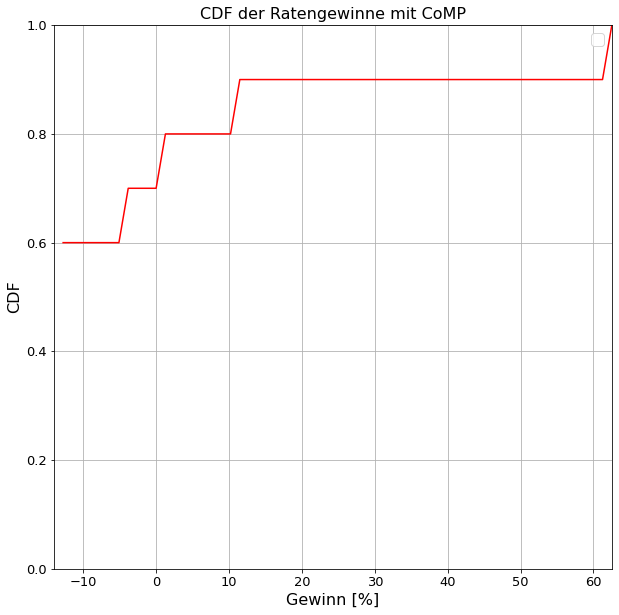

In [352]:
av=0
liste=np.array([])
ue=speicher[1800]
for i in ue[0:10]:
    liste=np.append(liste,((i.mR2/i.mR)-1)*100)
    av+=i.mR2/i.mR
av=av/(ue_nr*2)
print('CoMP-gain',av)

sh.cdf_1(liste,'','red','CDF der Ratengewinne mit CoMP',min(liste),max(liste),'Gewinn [%]',60)

In [353]:
load2[13]

168.0

## Same Rate Scheduling

In [312]:
dict2={}
sched_metric=[0,1]
queue_len=np.array([])

load1_1=np.array([])
load2_1=np.array([])
for k in ran[0:20]:
    print('new round',k)
    df=df2
    env=simpy.Environment()

    ue_dict=eds.df_to_ue_lists(df,[19,20],6,env)
    ue_all=np.array([])
    for i in cluster:
        ue_all=np.append(ue_all,ue_dict[i])

    prb_number_comp=eds.calculate_prb_number2(ue_all,max_prb)
    prb_number_normal=max_prb-prb_number_comp

    #Start processes

    for i in cluster:
        ue_list=ue_dict[i]
        for j in np.arange(0,ue_nr):
            env.process(ue_list[j].best_effort(env,10*(k)))

    ue_comp=np.array([]) #ues that use comp -> processed be central_scheduler
    for i in cluster:
        ue_list=ue_dict[i]
        new_ue_list=np.array([])
        for j in ue_list:
            if(j.comp == 0):
                new_ue_list=np.append(new_ue_list,j)
            else:
                ue_comp=np.append(ue_comp,j)
        ue_dict[i]=new_ue_list #user without comp

    env.process(eds.central_scheduler(env,ue_comp,SCHEDULE_T,[19,20],prb_number_comp,sched_metric))

    counter=0
    for i in cluster:
        ue_list=ue_dict[i]
        ue_19=ue_all[counter*ue_nr:((counter+1)*ue_nr)]
        env.process(eds.scheduler(env,ue_19,SCHEDULE_T,[19,20],max_prb,ue_list,prb_number_normal,sched_metric))
        counter=counter+1
    env.run(until=3000)
             
    av=0
    empty=0
    liste=np.array([])
    for i in ue_all:
        liste=np.append(liste,((i.mR2/i.mR)-1)*100)
        av+=i.mR2/i.mR
        if(i.queue.level!=0):
            empty=1

    queue_len=np.append(queue_len, empty)
    av=av/(ue_nr*2)
    dict2.update({k:liste})
    
    count=0
    count2=0
    for i in ue_all[0:10]:
        count+=np.ceil(k/i.tbs)
    for i in ue_all[10:20]:
        count2+=np.ceil(k/i.tbs)
    
    total=max_prb*5 #total number of prbs
    
    load1_1=np.append(load1_1,count*100/total)
    load2_1=np.append(load2_1,count2*100/total)
    

new round 600


C:\Users\Caroline Zoll\EDS\eds.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((i.cp)**e1/(i.mR**e2)))
C:\Users\Caroline Zoll\EDS\eds.py:211: RuntimeWarning: divide by zero encountered in double_scalars
  metric=np.append(metric,((cp)**e1/(i.mR2)**e2))


new round 700
new round 800
new round 900
new round 1000
new round 1100
new round 1200
new round 1300
new round 1400
new round 1500
new round 1600
new round 1700
new round 1800
new round 1900


(54.0, 171.2)

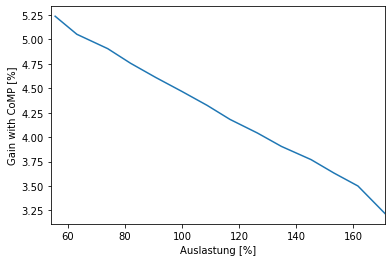

In [313]:
l=np.array([])
l2=np.array([])
for i in ran:
    x=dict2.get(i)
    m=x[0:ue_nr].mean()
    m2=x[ue_nr:ue_nr*2].mean()
    l=np.append(l,m)
    l2=np.append(l2,m2)
min_val=min(np.append(load1_1,load2_1))
max_val=max(np.append(load1_1,load2_1))

plt.plot(load1_1,l,)
plt.xlabel('Auslastung [%]')
plt.ylabel('Gain with CoMP [%]')
ax = plt.gca()
ax.set_xlim([min_val,max_val])

Text(0, 0.5, 'Gain with CoMP [%]')

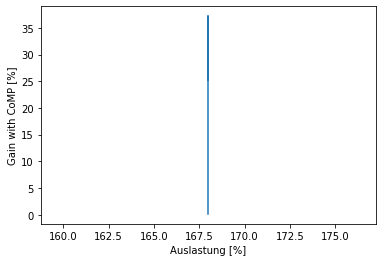

In [310]:
plt.plot(load2_1,l2,)
plt.xlabel('Auslastung [%]')
plt.ylabel('Gain with CoMP [%]')
ax = plt.gca()
ax.set_xlim([min_val,max_val])